### Preprocessing - Time Series<a id='preprocessing'>

## Contents<a id='Contents'></a>
* [Time Series - Preprocessing](#preprocessing)
  * [Contents](#Contents)
    * [Imports](#imports)
    * [Load The EDA - Crime reports Data](#load_data)
    * [Preparing Time Series for Top Ten crimes in APD sectors George and Baker](#choosing_crimes)
        
         * [Decomposition](#decomposition)
         * [Testing for Stationarity using KPSS](#stationarity_test)
         * [ADFuller test to test for stationarity](#adfuller_test)
         * [Autocorrelation and Partial Autocorrelation plots](#acf_pacf)
         * [Train_test split](#train_test_split)
         * [ARIMA Modeling](#arima)
         * [auto_arima grid search to find the best paramaters for our model](#auto_arima_grid)
           
         * [Simple Forecast Methods](#simple_forecast_methods)
         * [Simple Exponential Smoothing Method](#simple_exponential_method)
         * [Baseline Modeling](#baseline_modeling) 
         * [Create Time Series Features](#create_ts_features)
         * [Create XGBoost Model](#create_xgb)
                      
    * [Summary of Preprocessing](#summary)

### Imports<a id='imports'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow as pa
import pyarrow.parquet as pq
from pylab import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#from skforecast.model_selection_statsmodels import backtesting_sarimax
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from sklearn.pipeline import make_pipeline
#from xgboost import plot_importance, plot_tree
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

### Load Data<a id='load_data'>

In [2]:
#load dataset
df_crimes_summary = pd.read_csv('apd_crimes_summary.csv', parse_dates=['occurred_date_time'])

In [3]:
df_crimes_summary.shape

(75713, 26)

In [4]:
#this dataframe list top ten crimes which occur in the zip code 78701 under census_tract 11 which falls under council_district 9.
#Top ten crimes are : ASSAULT BY CONTACT,ASSAULT WITH INJURY,BURGLARY OF VEHICLE,CRIMINAL MISCHIEF,DISTURBANCE - OTHER,DWI,POSS OF DRUG PARAPHERNALIA,THEFT,VIOL CITY ORDINANCE - OTHER,WARRANT ARREST NON TRAFFIC

In [5]:
df_crimes_summary.head()

incident_report_number           crime_type  ucr_code family_violence  \
0             20141571614  ASSAULT WITH INJURY       900               N   
1              2015440640                THEFT       600               N   
2             20193401291                THEFT       600               N   
3             20173141730   ASSAULT BY CONTACT       902               N   
4             20215035126                THEFT       600               N   

          location_type                    address           clearance_date  \
0      RESIDENCE / HOME        900 BLOCK E 32ND ST  2014-06-12T00:00:00.000   
1      RESIDENCE / HOME         700 BLOCK E 8TH ST  2015-02-24T00:00:00.000   
2      RESIDENCE / HOME    1500 BLOCK RED RIVER ST  2020-02-04T00:00:00.000   
3  HOTEL / MOTEL / ETC.  500 BLOCK N IH 35 SVRD SB  2017-11-29T00:00:00.000   
4      RESIDENCE / HOME      8000 BLOCK CHERVIL DR                      NaN   

  clearance_status  zip_code  council_district  ... latitude  longitude  \
0                N   78705.0               9.0  ...      NaN        NaN   
1                N   78701.0               9.0  ...      NaN        NaN   
2                N   78701.0               1.0  ...      NaN        NaN   
3                N   78701.0               9.0  ...      NaN        NaN   
4              NaN   78759.0              10.0  ...      NaN        NaN   

   location  occurred_date_time   reported_date_time  occurred_date  year  \
0       NaN 2014-06-01 22:00:00  2014-06-06 20:47:00     2014-06-01  2014   
1       NaN 2015-02-05 14:00:00  2015-02-13 12:39:00     2015-02-05  2015   
2       NaN 2019-11-29 09:18:00  2019-12-06 20:47:00     2019-11-29  2019   
3       NaN 2017-11-10 21:42:00  2017-11-10 21:42:00     2017-11-10  2017   
4       NaN 2021-08-30 08:00:00  2021-10-24 12:25:00     2021-08-30  2021   

    month     day    hour  
0  2014.0  2014.0  2014.0  
1  2015.0  2015.0  2015.0  
2  2019.0  2019.0  2019.0  
3  2017.0  2017.0  2017.0  
4  2021.0  2021.0  2021.0  

[5 rows x 26 columns]

In [6]:
col_names = ['crime_type','occurred_date_time','occurred_date','year']

In [7]:
df_crimes_types = df_crimes_summary.loc[:,col_names]

In [8]:
df_crimes_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75713 entries, 0 to 75712
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   crime_type          75713 non-null  object        
 1   occurred_date_time  75713 non-null  datetime64[ns]
 2   occurred_date       75713 non-null  object        
 3   year                75713 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB


In [9]:
df_crimes_types.crime_type.value_counts()

THEFT                         15365
BURGLARY OF VEHICLE           15000
ASSAULT BY CONTACT             7843
CRIMINAL MISCHIEF              7099
ASSAULT WITH INJURY            5940
DWI                            5783
FAMILY DISTURBANCE             5675
THEFT OF BICYCLE               4686
WARRANT ARREST NON TRAFFIC     4368
DISTURBANCE - OTHER            3954
Name: crime_type, dtype: int64

### Preparing Time Series for Top Ten crimes in APD sectors George and Baker<a id='choosing_crimes'>

In [10]:
df_crimes_types.head()

crime_type  occurred_date_time occurred_date  year
0  ASSAULT WITH INJURY 2014-06-01 22:00:00    2014-06-01  2014
1                THEFT 2015-02-05 14:00:00    2015-02-05  2015
2                THEFT 2019-11-29 09:18:00    2019-11-29  2019
3   ASSAULT BY CONTACT 2017-11-10 21:42:00    2017-11-10  2017
4                THEFT 2021-08-30 08:00:00    2021-08-30  2021

In [11]:
# extracting the week from the date
df_crimes_types['weekNumber'] = df_crimes_types['occurred_date_time'].dt.week

In [12]:
#df_theft_18 = df_theft[df_theft.occurred_date.between('2013-01-01', '2023-04-01')]

In [13]:
df_crimes_types['day'] = df_crimes_types['occurred_date_time'].dt.day 

In [14]:
df_crimes_types.head()

crime_type  occurred_date_time occurred_date  year  weekNumber  \
0  ASSAULT WITH INJURY 2014-06-01 22:00:00    2014-06-01  2014          22   
1                THEFT 2015-02-05 14:00:00    2015-02-05  2015           6   
2                THEFT 2019-11-29 09:18:00    2019-11-29  2019          48   
3   ASSAULT BY CONTACT 2017-11-10 21:42:00    2017-11-10  2017          45   
4                THEFT 2021-08-30 08:00:00    2021-08-30  2021          35   

   day  
0    1  
1    5  
2   29  
3   10  
4   30

In [15]:
df_crimes_types_gp = df_crimes_types.groupby(['occurred_date']).agg(
   crime_count=('crime_type', 'count'),
    
 ).reset_index()

In [16]:
df_crimes_types_gp.sort_values(by = ['occurred_date'], ascending = [True])

occurred_date  crime_count
0       2013-01-01           38
1       2013-01-02           10
2       2013-01-03           14
3       2013-01-04           27
4       2013-01-05           26
...            ...          ...
3717    2023-03-07           10
3718    2023-03-08            8
3719    2023-03-09            7
3720    2023-03-10           13
3721    2023-03-11           13

[3722 rows x 2 columns]

In [17]:
df_daily_crimes_2022 = df_crimes_types_gp.loc[df_crimes_types_gp['occurred_date'] > '2022-03-10']

In [18]:
df_daily_crimes_2022.set_index('occurred_date',inplace=True)

In [19]:
df_daily_crimes_2022.index = pd.to_datetime(df_daily_crimes_2022.index)
 
# dates which are not in the sequence
# are returned
print(pd.date_range(
  start="2022-03-11", end="2023-03-11").difference(df_daily_crimes_2022.index))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [20]:
df_daily_crimes_2022

crime_count
occurred_date             
2022-03-11              13
2022-03-12               8
2022-03-13              23
2022-03-14              16
2022-03-15              16
...                    ...
2023-03-07              10
2023-03-08               8
2023-03-09               7
2023-03-10              13
2023-03-11              13

[366 rows x 1 columns]

In [21]:
df_daily_crimes_2022.reset_index(inplace=True)

In [22]:
fig = px.line(df_daily_crimes_2022, x='occurred_date', y='crime_count', title="Count of crimes for APD sectors George and Baker",template='plotly_dark')

fig.show()

In [23]:
df_daily_crimes_2022[df_daily_crimes_2022.crime_count == 0]

Empty DataFrame
Columns: [occurred_date, crime_count]
Index: []

In [24]:
len(df_daily_crimes_2022)

366

## Outlier detection and treatment

<AxesSubplot:xlabel='crime_count'>

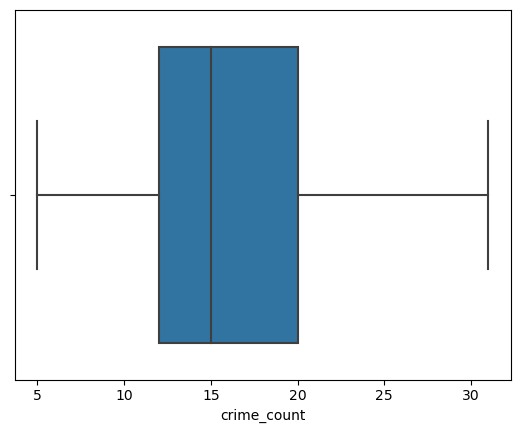

In [25]:
 sns.boxplot(x= df_daily_crimes_2022 ['crime_count'])

### I don't see any outliers. 
Just to doube check, I wil get the z_scores

In [26]:
#df_daily_crimes_2022 ['z_score'] = (df_daily_crimes_2022['crime_count'] - df_daily_crimes_2022['crime_count'].mean())/df_daily_crimes_2022['crime_count'].std(ddof=0)

In [27]:
#exclude the rowl with z score more than 3
#from scipy import stats
#df_daily_crimes_2022[(np.abs(stats.zscore(df_daily_crimes_2022['z_score'])) < 3)]

In [28]:
df_daily_crimes_2022.set_index('occurred_date',inplace=True)

In [29]:
df_daily_crimes_2022.head()

crime_count
occurred_date             
2022-03-11              13
2022-03-12               8
2022-03-13              23
2022-03-14              16
2022-03-15              16

In [30]:
y = df_daily_crimes_2022['crime_count']

In [31]:
y

occurred_date
2022-03-11    13
2022-03-12     8
2022-03-13    23
2022-03-14    16
2022-03-15    16
              ..
2023-03-07    10
2023-03-08     8
2023-03-09     7
2023-03-10    13
2023-03-11    13
Name: crime_count, Length: 366, dtype: int64

<AxesSubplot:xlabel='occurred_date'>

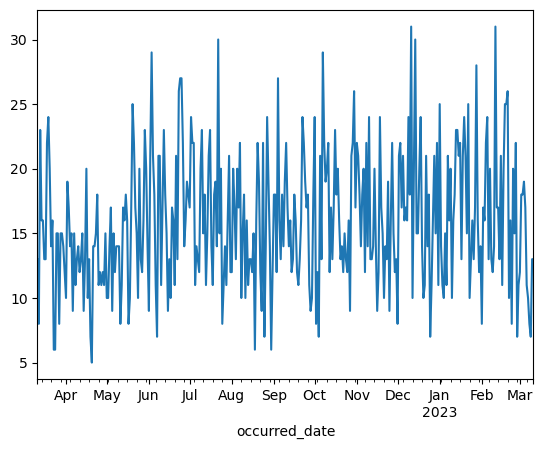

In [32]:
y.plot()

In [33]:
df_daily_crimes_2022.sort_index(inplace=True)

In [34]:
df_daily_crimes_2022.dtypes

crime_count    int64
dtype: object

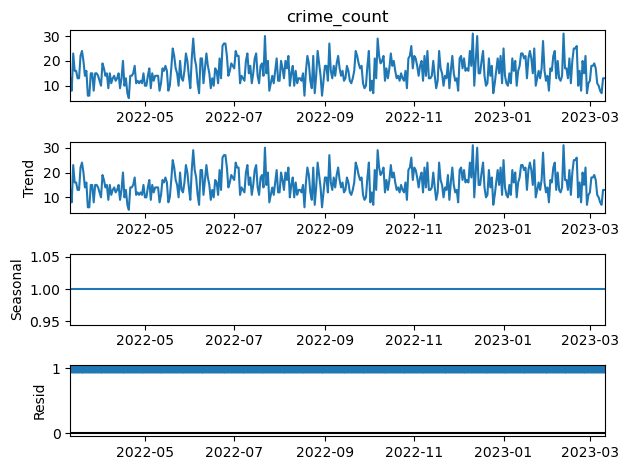

In [35]:
# Decompose the data frame to get the trend, seasonality and noise
decompose_result = seasonal_decompose(df_daily_crimes_2022['crime_count'],model='multiplicative',period=1)
decompose_result.plot()
plt.show()

### Testing for Stationarity using KPSS<a id='stationarity_test'>
    Kwiatkowski-Phillips-Schmidt-Shin Test

In [36]:
from statsmodels.tsa.stattools import kpss

statistic, p_value, n_lags, critical_values = kpss(df_daily_crimes_2022, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  0.6881811706860992
p-value:  0.014619893573990982
Number of Lags:  2
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


#### p-value is 0.01 and is lower than 0.05. So we have to deduce the data to be non-stationary

### ADFuller test to test for stationarity<a id='adfuller_test'>

In [37]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    print() #empty line for formatting
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")



In [38]:
adf_test(df_daily_crimes_2022)

Augmented Dickey-Fuller Test: 

ADF test statistic       -3.486526
p-value                   0.008340
# lags used              13.000000
# observations          352.000000
critical value (1%)      -3.449065
critical value (5%)      -2.869786
critical value (10%)     -2.571163

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is STATIONARY


In [39]:
df_daily_crimes_2022.head()

crime_count
occurred_date             
2022-03-11              13
2022-03-12               8
2022-03-13              23
2022-03-14              16
2022-03-15              16

In [40]:
# Declare a variable called y_log
y_log = np.log(df_daily_crimes_2022)

<AxesSubplot:xlabel='occurred_date'>

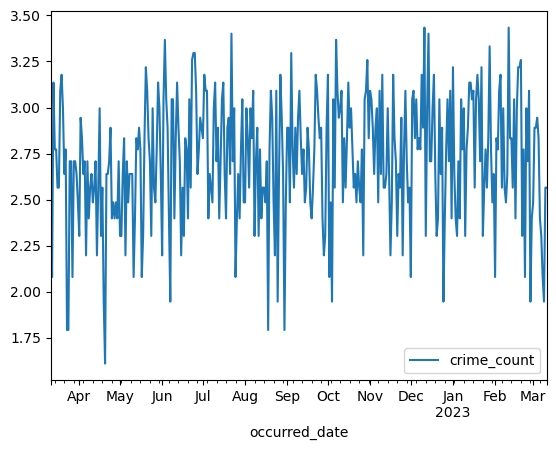

In [41]:
y_log.plot()

In [42]:
y_diff=y_log.diff().dropna()

<AxesSubplot:xlabel='occurred_date'>

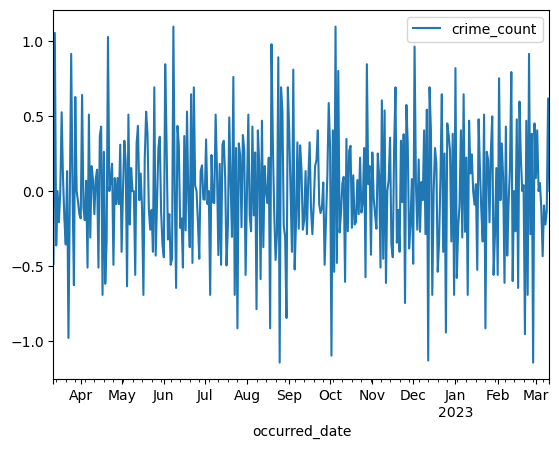

In [43]:
y_diff.plot()

In [44]:
kpss(y_diff)

(0.08291419630450753,
 0.1,
 53,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Data is now stationary!

## Train Test Split using y_diff

In [45]:
y_log

crime_count
occurred_date             
2022-03-11        2.564949
2022-03-12        2.079442
2022-03-13        3.135494
2022-03-14        2.772589
2022-03-15        2.772589
...                    ...
2023-03-07        2.302585
2023-03-08        2.079442
2023-03-09        1.945910
2023-03-10        2.564949
2023-03-11        2.564949

[366 rows x 1 columns]

In [46]:
#len(y_diff) - 365
#len(X_final_train) 351
#len(y_final_test) 15
# X_final_train.index - RangeIndex(start=0, stop=351, step=1)

In [47]:
X_final_train = y_log.iloc[:len(y_diff)-14]
y_final_test = y_log.drop(X_final_train.index)

In [48]:
X_final_train

crime_count
occurred_date             
2022-03-11        2.564949
2022-03-12        2.079442
2022-03-13        3.135494
2022-03-14        2.772589
2022-03-15        2.772589
...                    ...
2023-02-20        3.258097
2023-02-21        2.302585
2023-02-22        2.772589
2023-02-23        2.079442
2023-02-24        2.995732

[351 rows x 1 columns]

### Plotting ACFS and PACF<a id='acf_pacf'>

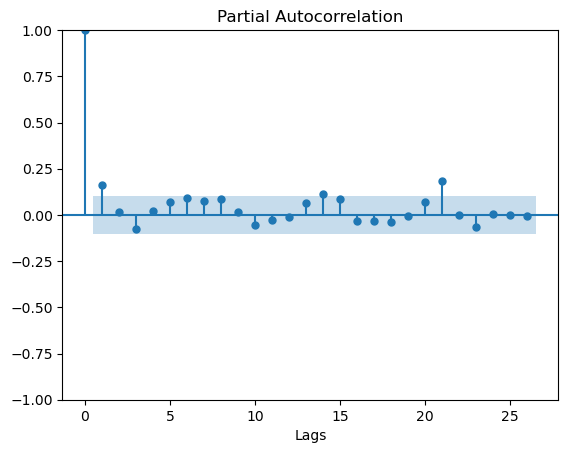

In [49]:
plot_pacf(np.array(X_final_train.crime_count))
plt.xlabel('Lags')
plt.show()

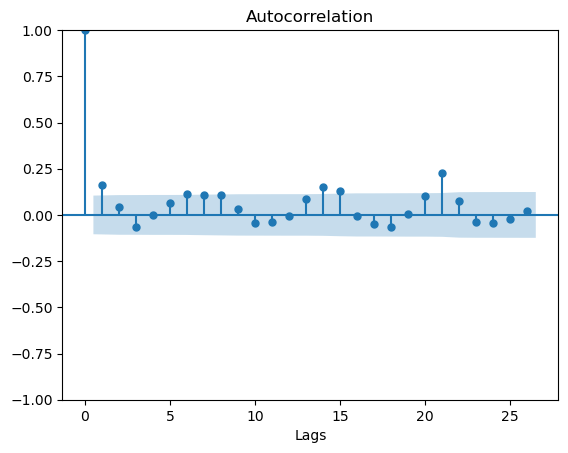

In [50]:
plot_acf(np.array(X_final_train.crime_count))
plt.xlabel('Lags')
plt.show()

In [51]:
from pmdarima.arima.utils import ndiffs

ndiffs(X_final_train['crime_count'])

1

In [52]:
from pmdarima.arima import nsdiffs
nsdiffs(X_final_train['crime_count'],12)

0

### Simple Forecast Methods
Based on Rob J Hyndman and George Athanasopoulos"
Forecasting: Principles and Practice; 3rd Edition
https://otexts.com/fpp3/

In [53]:
y_hat_naive = y_final_test.copy()
y_hat_naive['naive_forecast'] = X_final_train['crime_count'][len(X_final_train)-1]

In [54]:
y_hat_naive

crime_count  naive_forecast
occurred_date                             
2023-02-25        2.708050        2.995732
2023-02-26        3.091042        2.995732
2023-02-27        1.945910        2.995732
2023-02-28        2.397895        2.995732
2023-03-01        2.484907        2.995732
2023-03-02        2.890372        2.995732
2023-03-03        2.890372        2.995732
2023-03-04        2.944439        2.995732
2023-03-05        2.833213        2.995732
2023-03-06        2.397895        2.995732
2023-03-07        2.302585        2.995732
2023-03-08        2.079442        2.995732
2023-03-09        1.945910        2.995732
2023-03-10        2.564949        2.995732
2023-03-11        2.564949        2.995732

### Naive method

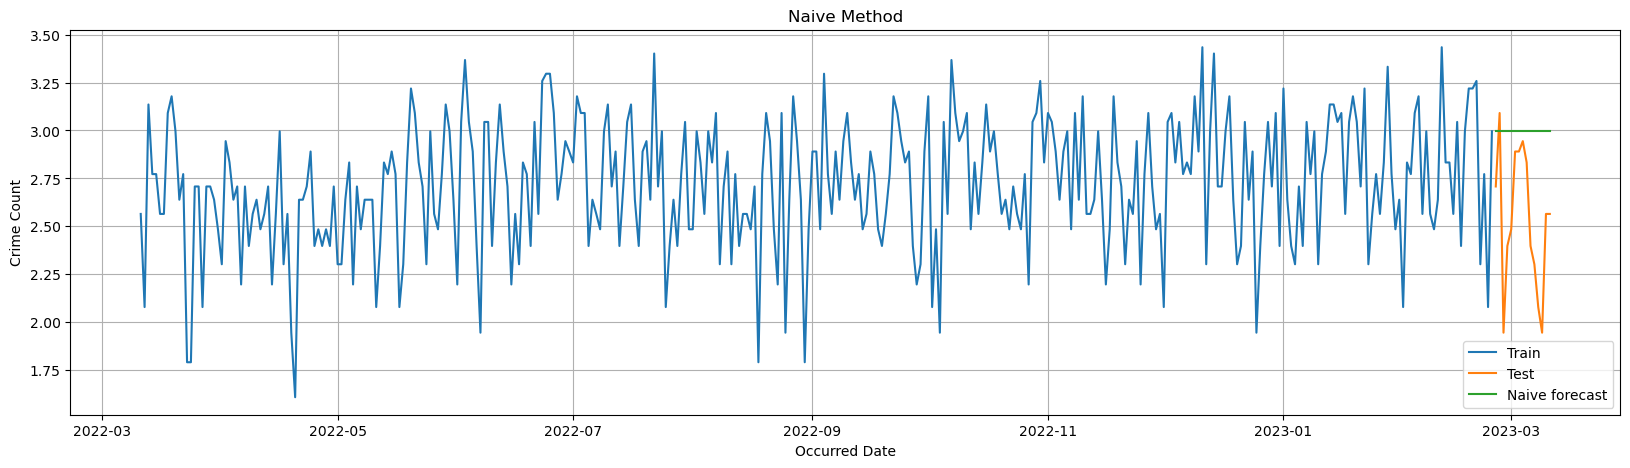

In [55]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(X_final_train['crime_count'], label='Train')
plt.plot(y_final_test['crime_count'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.xlabel('Occurred Date')
plt.ylabel('Crime Count')
plt.show()

### Calculate RMSE and MAPE

In [56]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_final_test['crime_count'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(y_final_test['crime_count']-y_hat_naive['naive_forecast'])/y_final_test['crime_count'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

Method  RMSE   MAPE
0  Naive method  0.58  20.97

### Simple Average Method

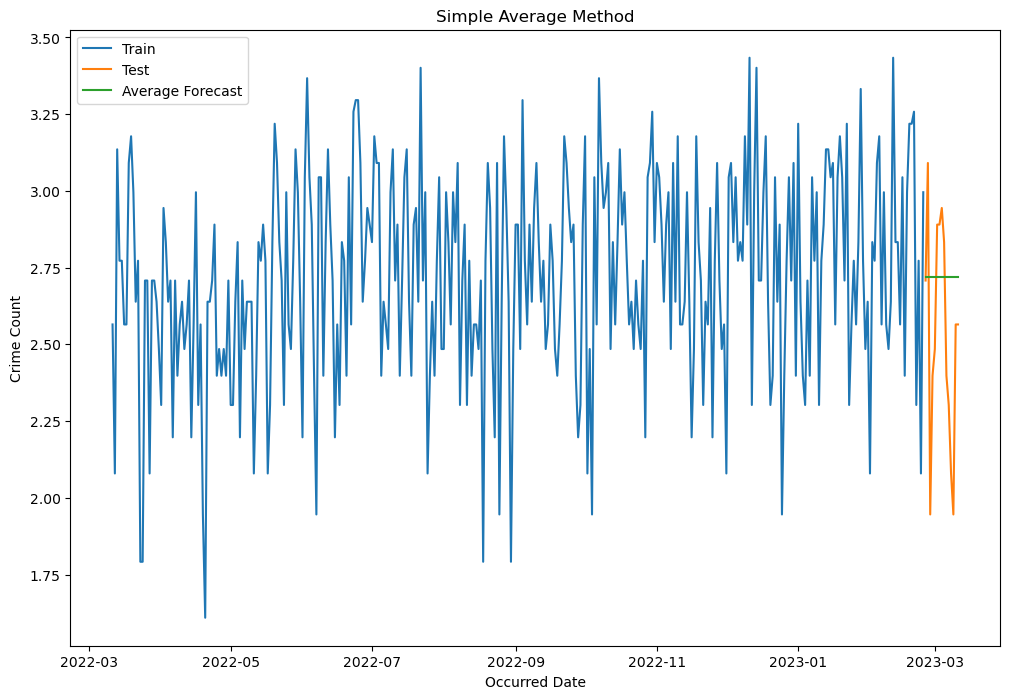

In [57]:
y_hat_avg = y_final_test.copy()
y_hat_avg['avg_forecast'] = X_final_train['crime_count'].mean()
plt.figure(figsize=(12,8))
plt.plot(X_final_train['crime_count'], label='Train')
plt.plot(y_final_test['crime_count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.xlabel('Occurred Date')
plt.ylabel('Crime Count')
plt.show()

In [58]:

rmse = np.sqrt(mean_squared_error(y_final_test['crime_count'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(y_final_test['crime_count']-y_hat_avg['avg_forecast'])/y_final_test['crime_count'])*100,2)

results = pd.DataFrame({'Method':['Simple Average method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

Method  RMSE   MAPE
0  Simple Average method   0.4  14.17

## Forecasting with Holt Winter's method

In [59]:
# holt winters 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # single exponential smoothing as in ewm of pandas
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing

In [60]:
fitted_model = ExponentialSmoothing(X_final_train['crime_count']).fit()

In [61]:
test_predictions = fitted_model.forecast(15).rename('HW Test Forecast')

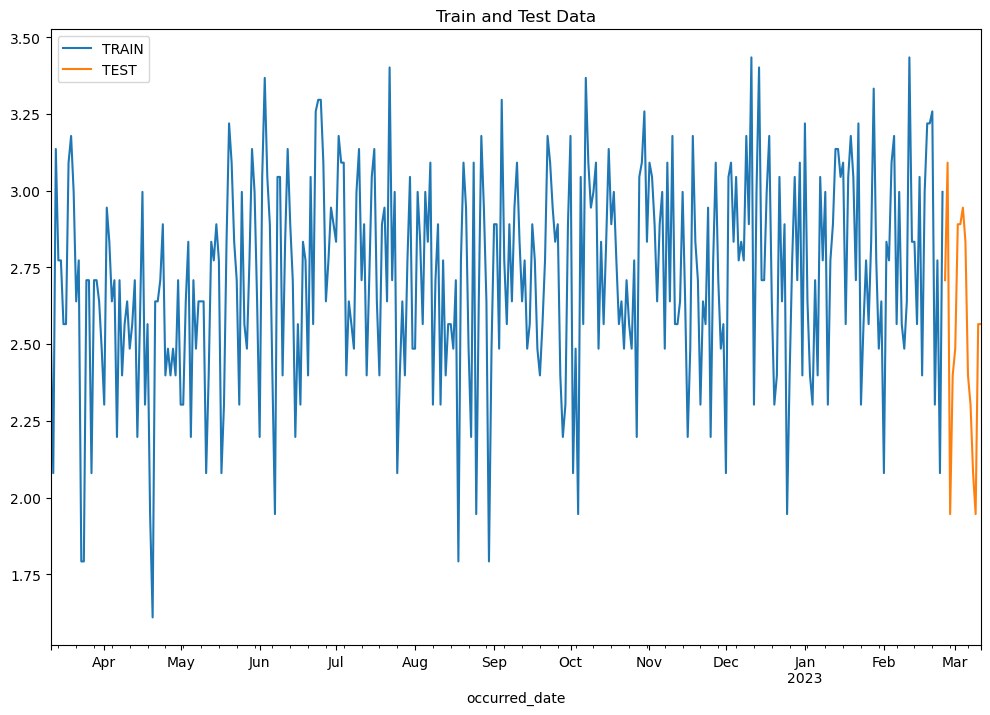

In [62]:
X_final_train['crime_count'].plot(legend=True,label='TRAIN')
y_final_test['crime_count'].plot(legend=True,label='TEST',figsize=(12,8))
plt.title('Train and Test Data');

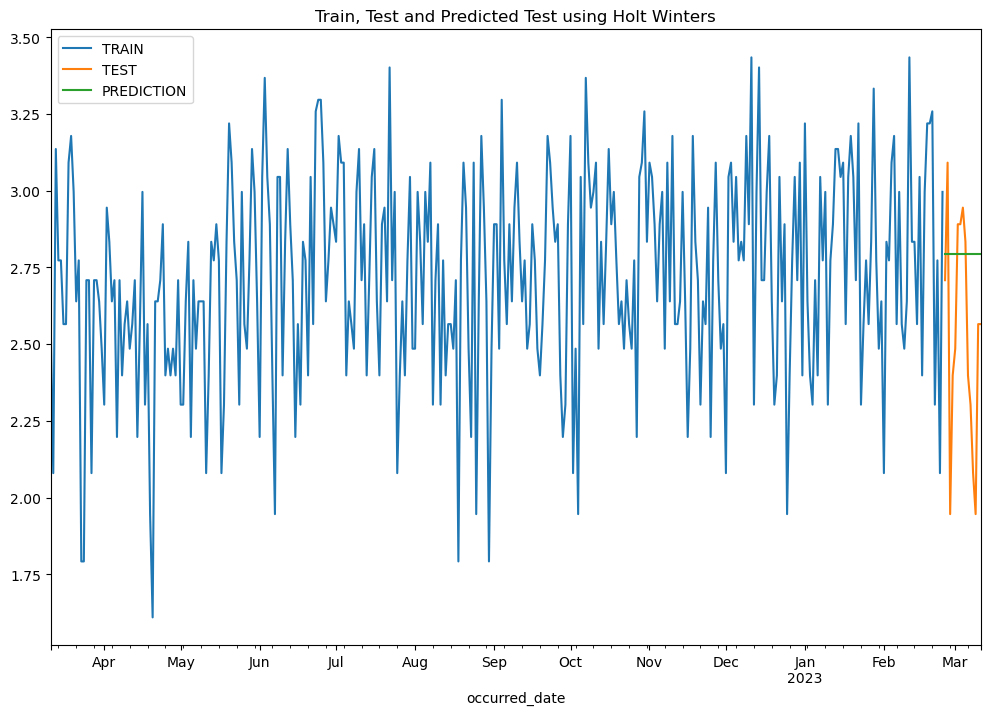

In [63]:
X_final_train['crime_count'].plot(legend=True,label='TRAIN')
y_final_test['crime_count'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

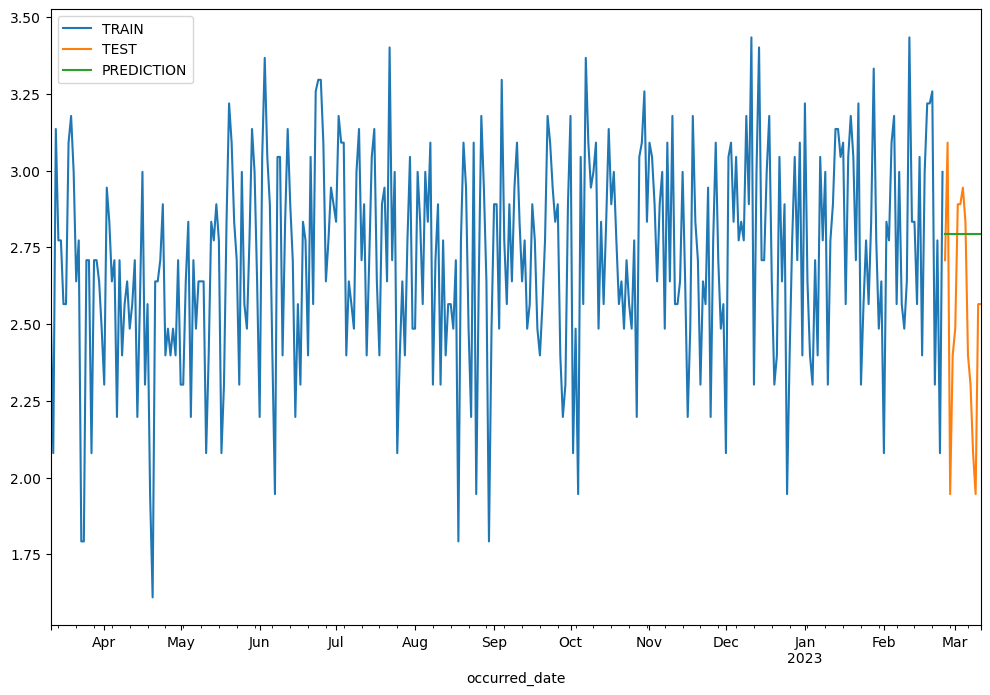

In [64]:
X_final_train['crime_count'].plot(legend=True,label='TRAIN')
y_final_test['crime_count'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

### Evaluation Metrics

In [65]:
mean_absolute_error(y_final_test['crime_count'],test_predictions)

0.34821984433687375

In [66]:
rmse = np.sqrt(mean_squared_error(y_final_test['crime_count'],test_predictions)).round(2)
mape = np.round(np.mean(np.abs(y_final_test['crime_count']-test_predictions)/y_final_test['crime_count'])*100,2)
results = pd.DataFrame({'Method':['Holt Winter\'s method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

Method  RMSE   MAPE
0  Holt Winter's method  0.43  15.46

### Forecast into future

In [67]:
final_model = ExponentialSmoothing(df_daily_crimes_2022['crime_count']).fit()

In [68]:
forecast_predictions = final_model.forecast(steps=36)

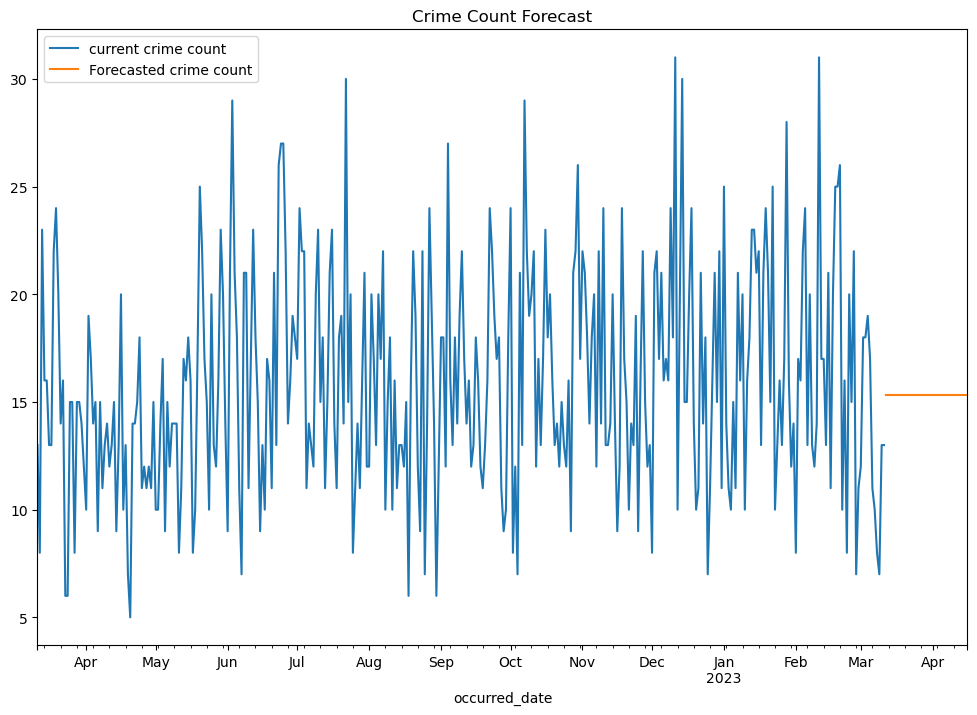

In [69]:
df_daily_crimes_2022['crime_count'].plot(figsize=(12,8),legend=True,label='current crime count')
forecast_predictions.plot(legend=True,label='Forecasted crime count')
plt.title('Crime Count Forecast');

### auto_arima grid search to find the parameters

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=409.975, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=341.019, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=407.978, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=323.715, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=299.551, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=279.504, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=263.628, Time=0.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=261.630, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=277.505, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=225.017, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=223.143, Time=0.14 se

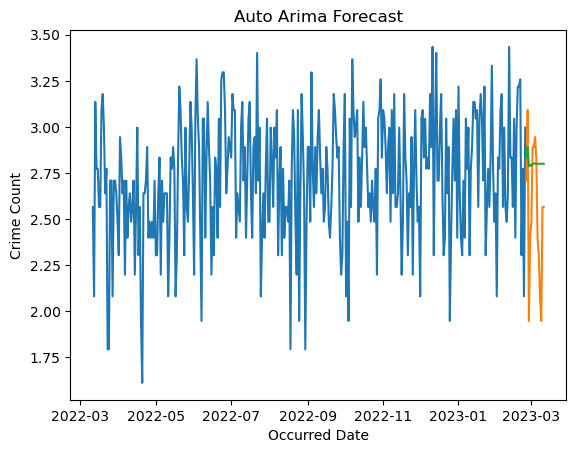

In [70]:
model = auto_arima(X_final_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(X_final_train)

forecast = model.predict(n_periods=len(y_final_test))
forecast = pd.DataFrame(forecast,index = y_final_test.index,columns=['crime_count'])

#plot the predictions for validation set
plt.plot(X_final_train, label='Train')
plt.plot(y_final_test, label='Test')
plt.plot(forecast, label='Crime Count')
plt.title('Auto Arima Forecast')
plt.xlabel('Occurred Date')
plt.ylabel('Crime Count')
plt.show()

### ARIMA<a id='arima'>

In [71]:
model_ar = ARIMA(X_final_train, order=(3,1,1))
model_fit = model_ar.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            crime_count   No. Observations:                  351
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -105.725
Date:                Tue, 21 Mar 2023   AIC                            221.450
Time:                        11:54:08   BIC                            240.740
Sample:                    03-11-2022   HQIC                           229.128
                         - 02-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1159      0.055      2.110      0.035       0.008       0.223
ar.L2         -0.0094      0.058     -0.162      0.871      -0.122       0.104
ar.L3         -0.1233      0.054     -2.282      0.0

In [72]:
# make predictions using forecast method
predictions_f_ms = model_fit.forecast(steps=len(y_final_test))
mse=mean_squared_error(y_final_test, predictions_f_ms)
print("Mean Square Error based on ARIMA method(): ",mse)

Mean Square Error based on ARIMA method():  0.18743138865905445


In [73]:
rmse = sqrt(mse)
print("Root Mean Square Error based on ARIMA method(): ",rmse)

Root Mean Square Error based on ARIMA method():  0.43293346909086905


In [74]:
mae_ar_method = mean_absolute_error(y_final_test, predictions_f_ms)
print("Mean Absolute Error based on ARIMA method: ",mae_ar_method)

Mean Absolute Error based on ARIMA method:  0.34405426064578476


In [75]:
def absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.abs((y_true - y_pred) / y_true) * 100

In [76]:
ape = absolute_percentage_error(y_final_test, predictions_f_ms)
print("Absolute Percentage Error based on ARIMA method: ",ape)

Absolute Percentage Error based on ARIMA method:  [[4.58808321e+00 6.72844762e+00 2.86066719e+00 3.13664740e+00
  2.94087967e+00 3.39254427e+00 3.41268186e+00 3.43493044e+00
  3.38162600e+00 3.37275803e+00 3.36948560e+00 3.37576225e+00
  3.37761367e+00 3.37817301e+00 3.37744655e+00]
 [8.37078946e+00 6.49562456e+00 9.88417187e+00 9.64238668e+00
  9.81389803e+00 9.41819644e+00 9.40055397e+00 9.38106208e+00
  9.42776190e+00 9.43553109e+00 9.43839805e+00 9.43289910e+00
  9.43127708e+00 9.43078704e+00 9.43142350e+00]
 [4.55513143e+01 4.85299792e+01 4.31473342e+01 4.35314055e+01
  4.32589629e+01 4.38875276e+01 4.39155523e+01 4.39465149e+01
  4.38723331e+01 4.38599918e+01 4.38554377e+01 4.38641727e+01
  4.38667493e+01 4.38675277e+01 4.38665167e+01]
 [1.81159924e+01 2.05332015e+01 1.61651443e+01 1.64768211e+01
  1.62557319e+01 1.67658169e+01 1.67885592e+01 1.68136855e+01
  1.67534864e+01 1.67434714e+01 1.67397757e+01 1.67468642e+01
  1.67489551e+01 1.67495868e+01 1.67487663e+01]
 [1.39800482e+

In [77]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [78]:
mape = mean_absolute_percentage_error(y_final_test, predictions_f_ms)
print("Mean Absolute Percentage Error based on ARIMA method: ",mape)

Mean Absolute Percentage Error based on ARIMA method:  15.700412314088789


### Simple Exponential Smoothing Method<a id='simple_exponential_smoothing_method'>
<br />Exponential smoothing is a method for forecasting univariate time series data. <br />
It is based on the principle that a prediction is a weighted linear sum of past observations or lags.<br />
The Exponential Smoothing time series method works by assigning exponentially decreasing weights for past observations.

In [79]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

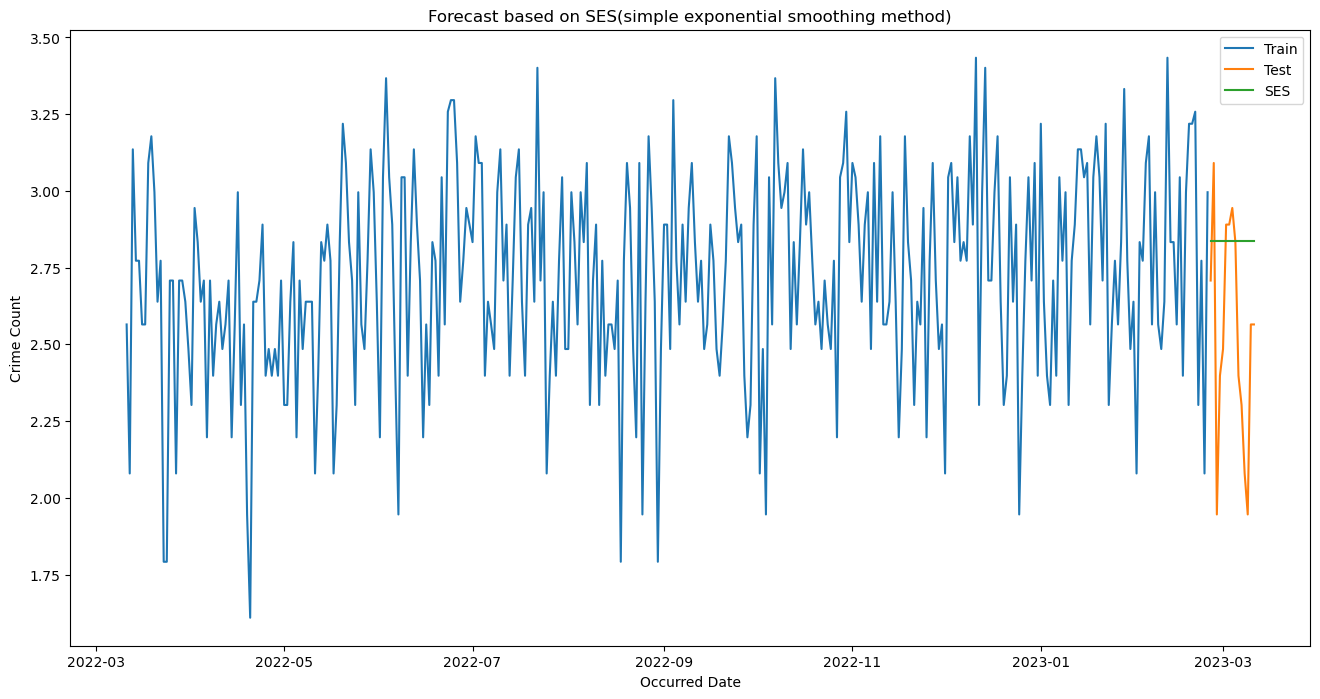

In [80]:
y_hat_avg = y_final_test.copy()
fit2 = SimpleExpSmoothing(X_final_train['crime_count']).fit(smoothing_level=0.8,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(y_final_test))
                        
plt.figure(figsize=(16,8))
plt.plot(X_final_train['crime_count'], label='Train')
plt.plot(y_final_test['crime_count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.title('Forecast based on SES(simple exponential smoothing method)')
plt.xlabel('Occurred Date')
plt.ylabel('Crime Count')
plt.show()



In [81]:
mse_exp_method = mean_squared_error(y_final_test.crime_count, y_hat_avg.SES)
print("Mean Square Error based on Simple Exponential Smoothing method: ",mse_exp_method)

Mean Square Error based on Simple Exponential Smoothing method:  0.21414821093104586


In [82]:
rmse = sqrt(mse_exp_method)
print("Root Mean Square Error based on Simple Exponential Smoothing method: ",round(rmse,2))

Root Mean Square Error based on Simple Exponential Smoothing method:  0.46


In [83]:
mae_exp_method = mean_absolute_error(y_final_test.crime_count, y_hat_avg.SES)
print("Mean Absolute Error based on Simple Exponential Smoothing method: ",mae_exp_method)

Mean Absolute Error based on Simple Exponential Smoothing method:  0.3637455759494833


In [84]:
mape = mean_absolute_percentage_error(y_final_test.crime_count, y_hat_avg.SES)
print("Mean Absolute Percentage Error based on Simple Exponential Smoothing method: ",mape)

Mean Absolute Percentage Error based on Simple Exponential Smoothing method:  16.267015828073113


### Uni-Step Forecasting<a id='baseline_modeling'>


Since the number of burglary of vehicles  is not significant between any 2 days, it is reasonable to produce a most basic model in which it uses the current crime count as a prediction for the next day.

Here, I use 1-step prediction to model the crime count as a time series:

In [85]:
predicted_df = X_final_train['crime_count'].to_frame().shift(1).rename(columns={'crime_count': 'crime_count_predict'})
#predicted_2_df = X['theft_count'].to_frame().shift(2).rename(columns={'theft_count': 'theft_count_predict(t-2)'})
actual_df = X_final_train['crime_count'].to_frame().rename(columns={'crime_count': 'crime_count_actual'})

In [86]:
#concatenate the above two tables
one_step_df = pd.concat([actual_df,predicted_df,],axis=1)

In [87]:
one_step_df.head()

crime_count_actual  crime_count_predict
occurred_date                                         
2022-03-11               2.564949                  NaN
2022-03-12               2.079442             2.564949
2022-03-13               3.135494             2.079442
2022-03-14               2.772589             3.135494
2022-03-15               2.772589             2.772589

In [88]:
one_step_df = one_step_df[1:]

In [89]:
one_step_df.head()

crime_count_actual  crime_count_predict
occurred_date                                         
2022-03-12               2.079442             2.564949
2022-03-13               3.135494             2.079442
2022-03-14               2.772589             3.135494
2022-03-15               2.772589             2.772589
2022-03-16               2.564949             2.772589

#### 45-degree line<a id='baseline_45_deg'>

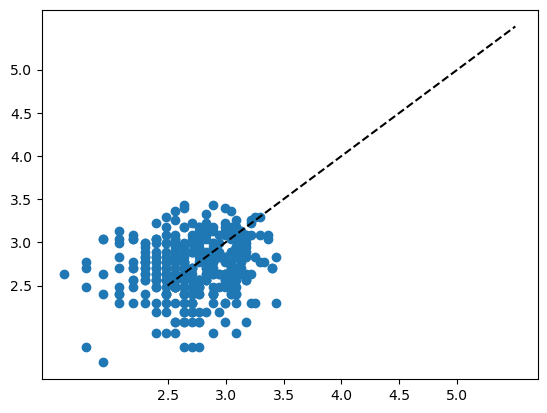

In [90]:
x = one_step_df['crime_count_predict']
y = one_step_df['crime_count_actual']
ticks = np.arange( 2.5, 5.5, step=0.5 )

plt.scatter(x, y, cmap='viridis')
plt.xticks( ticks )
plt.yticks( ticks )
plt.plot( [2.5,5.5], [2.5,5.5], linestyle='--', color='k' )
plt.show()

In [91]:
mse = mean_squared_error(one_step_df.crime_count_actual, one_step_df.crime_count_predict)
print("Mean Square Error based on one step shift: ",round(mse,2))

Mean Square Error based on one step shift:  0.19


In [92]:
rmse = sqrt(mean_squared_error(one_step_df.crime_count_actual, one_step_df.crime_count_predict))
print("Root Mean Square Error based on one step shift: ",round(rmse,2))

Root Mean Square Error based on one step shift:  0.43


In [93]:
mae = mean_absolute_error(one_step_df.crime_count_predict, one_step_df.crime_count_actual)
print("Mean Absolute Error based on one step shift: ",round(mae,2))

Mean Absolute Error based on one step shift:  0.35


In [94]:
mean_absolute_percentage_error(one_step_df.crime_count_actual,one_step_df.crime_count_predict)

13.285251869962797

### Summary of scores for Naive, simple average, Holt Winter's, Arima, uni-step predict

In [95]:
df_error_metrics = pd.DataFrame({
                   
                   "RMSE": [0.58,0.4,0.43,0.43,0.43],
                   
                    "MAPE": ['20.97%','14.17%','15.46%','15.7%','13.3%']             
                        },
                   index =['Naive','Simple Average' ,'Holt Winter\'s','Arima','uni-step'])
df_error_metrics

RMSE    MAPE
Naive           0.58  20.97%
Simple Average  0.40  14.17%
Holt Winter's   0.43  15.46%
Arima           0.43   15.7%
uni-step        0.43   13.3%

## converting to supervised problem<a id='create_lags'>

In [96]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
     
    #print("n_in and n_out :", n_in, n_out)  
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
     # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        #print("i in n_out: ",i, n_out)
        cols.append(df.shift(-i))
        if i == 0:
            #print("i am here")
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg
 
 
data = series_to_supervised(X_final_train,2, 2)
print(data)

               var1(t-2)  var1(t-1)   var1(t)  var1(t+1)
occurred_date                                           
2022-03-13      2.564949   2.079442  3.135494   2.772589
2022-03-14      2.079442   3.135494  2.772589   2.772589
2022-03-15      3.135494   2.772589  2.772589   2.564949
2022-03-16      2.772589   2.772589  2.564949   2.564949
2022-03-17      2.772589   2.564949  2.564949   3.091042
...                  ...        ...       ...        ...
2023-02-19      2.995732   3.218876  3.218876   3.258097
2023-02-20      3.218876   3.218876  3.258097   2.302585
2023-02-21      3.218876   3.258097  2.302585   2.772589
2023-02-22      3.258097   2.302585  2.772589   2.079442
2023-02-23      2.302585   2.772589  2.079442   2.995732

[348 rows x 4 columns]


In [97]:

X = data.loc[:, ['var1(t-1)']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = data.loc[:, 'var1(t)']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

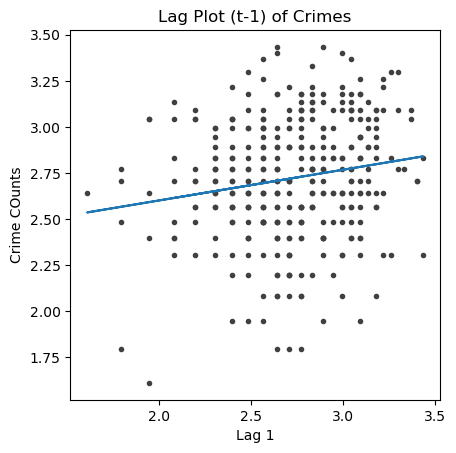

In [98]:
fig, ax = plt.subplots()
ax.plot(X['var1(t-1)'], y, '.', color='0.25')
ax.plot(X['var1(t-1)'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Crime COunts')
ax.set_xlabel('Lag 1')
ax.set_title('Lag Plot (t-1) of Crimes');

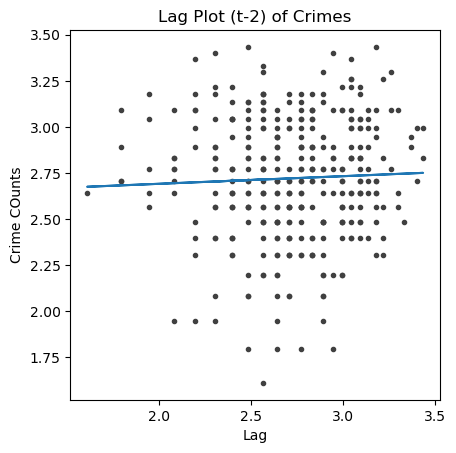

In [99]:
X = data.loc[:, ['var1(t-2)']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = data.loc[:, 'var1(t)']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots()
ax.plot(X['var1(t-2)'], y, '.', color='0.25')
ax.plot(X['var1(t-2)'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Crime COunts')
ax.set_xlabel('Lag')
ax.set_title('Lag Plot (t-2) of Crimes');

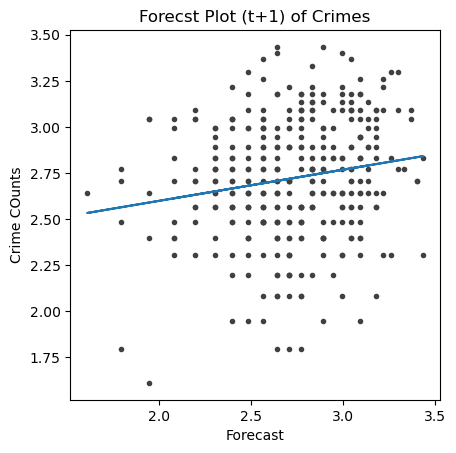

In [100]:
X = data.loc[:, ['var1(t)']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = data.loc[:, 'var1(t+1)']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
fig, ax = plt.subplots()
ax.plot(X['var1(t)'], y, '.', color='0.25')
ax.plot(X['var1(t)'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Crime COunts')
ax.set_xlabel('Forecast')
ax.set_title('Forecst Plot (t+1) of Crimes');

In [101]:
#import plotly.graph_objects as go #RandomForestRegressor
#names = lags.columns
#fig = go.Figure(data=[go.Bar(
#            x=lags.columns, y=model.feature_importances_,
#           text=model.feature_importances_,
#            textposition='auto',)])

#fig.show()

importance:  [0.15538579 0.02561024 0.1645408 ]
Feature: 0, Score: 0.15539
Feature: 1, Score: 0.02561
Feature: 2, Score: 0.16454


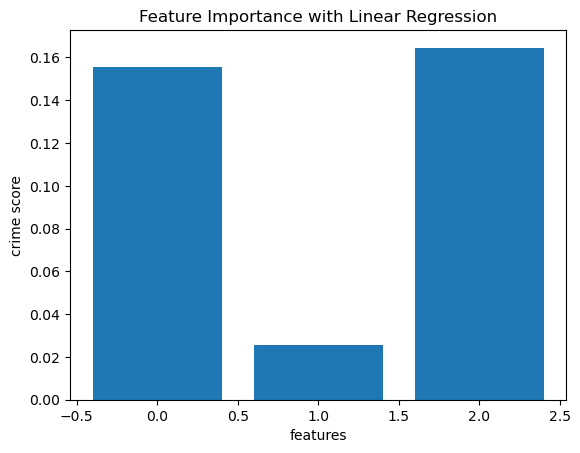

In [102]:
X = data.loc[:, ['var1(t-1)','var1(t-2)','var1(t+1)']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = data.loc[:, 'var1(t)']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)
# get importance
importance = model.coef_
print("importance: ",importance)
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel("features")
plt.ylabel("crime score")
plt.title("Feature Importance with Linear Regression")
plt.show()

#### I am assuming humar behaviour is hard to predict and hence the crimes. So lower score should be ok. 

## Create Time Series Features<a id='create_ts_features'>

In [103]:
df_daily_crimes_2022.reset_index(inplace=True)

In [104]:
df=df_daily_crimes_2022.loc[:,'occurred_date':'crime_count']

In [105]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['occurred_date'] = pd.to_datetime(df['occurred_date'])
    df['dayofweek'] = df['occurred_date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    df['month'] = df['occurred_date'].dt.month
    df['year'] = df['occurred_date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['crime_count'] = df['crime_count']
    df['lag_1'] = df['crime_count'].shift(1)
    df['lag_2'] = df['crime_count'].shift(2)
    df['f_1'] = df['crime_count'].shift(-1)
    df['crime_mean'] = df['crime_count'].rolling(window = 7).mean()
    df['crime_std'] = df['crime_count'].rolling(window = 7).std()
    df['crime_max'] = df['crime_count'].rolling(window = 7).max()
    df['crime_min'] = df['crime_count'].rolling(window = 7).min()
  
  
    
    X = df[['occurred_date','dayofweek','month','year',
           'lag_1' , 'lag_2' , 'f_1',
           'crime_mean' ,'crime_std' ,'crime_max' ,'crime_min','crime_count']]
    if label:
        y = df[label]
    return X, y
   # return X

In [106]:
X,y = create_features(df, label='crime_count')

In [107]:
X_feat_train = X[X.occurred_date.between('2022-03-11', '2023-02-24')]

In [108]:
X_feat_test = X[X.occurred_date.between('2023-02-25','2023-03-11')]

In [109]:
y_feat_train = y[:351]

In [110]:
y_feat_test = y[351:]

In [111]:
X_feat_train.shape, X_feat_test.shape,y_feat_train.shape, y_feat_test.shape

((351, 12), (15, 12), (351,), (15,))

In [112]:
X_feat_train[6:]

occurred_date  dayofweek  month  year  lag_1  lag_2   f_1  crime_mean  \
6      2022-03-17          3      3  2022   13.0   16.0  22.0   14.571429   
7      2022-03-18          4      3  2022   13.0   13.0  24.0   15.857143   
8      2022-03-19          5      3  2022   22.0   13.0  20.0   18.142857   
9      2022-03-20          6      3  2022   24.0   22.0  14.0   17.714286   
10     2022-03-21          0      3  2022   20.0   24.0  16.0   17.428571   
..            ...        ...    ...   ...    ...    ...   ...         ...   
346    2023-02-20          0      2  2023   25.0   25.0  10.0   20.142857   
347    2023-02-21          1      2  2023   26.0   25.0  16.0   19.714286   
348    2023-02-22          2      2  2023   10.0   26.0   8.0   19.000000   
349    2023-02-23          3      2  2023   16.0   10.0  20.0   18.571429   
350    2023-02-24          4      2  2023    8.0   16.0  15.0   18.571429   

     crime_std  crime_max  crime_min  crime_count  
6     4.577377       23.0        8.0           13  
7     5.273474       23.0        8.0           22  
8     4.740906       24.0       13.0           24  
9     4.347961       24.0       13.0           20  
10    4.540820       24.0       13.0           14  
..         ...        ...        ...          ...  
346   6.011893       26.0       11.0           26  
347   6.676184       26.0       10.0           10  
348   6.782330       26.0       10.0           16  
349   7.435436       26.0        8.0            8  
350   7.435436       26.0        8.0           20  

[345 rows x 12 columns]

In [113]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [114]:
X_train_reg = X_feat_train.iloc[6:]

In [115]:
# independent variable
x = X_train_reg['dayofweek']
  
# output variable (dependent)
y = X_train_reg['crime_count']
  
# adding constant
x = sm.add_constant(x)
  
#fit linear regression model
model_linear = sm.OLS(y, x).fit()
  
#display model summary
print(model_linear.summary())
  
# residual sum of squares
print(model_linear.ssr)

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     44.46
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           1.04e-10
Time:                        11:54:09   Log-Likelihood:                -1030.9
No. Observations:                 345   AIC:                             2066.
Df Residuals:                     343   BIC:                             2073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4119      0.469     28.619      0.0

eval_env: 1


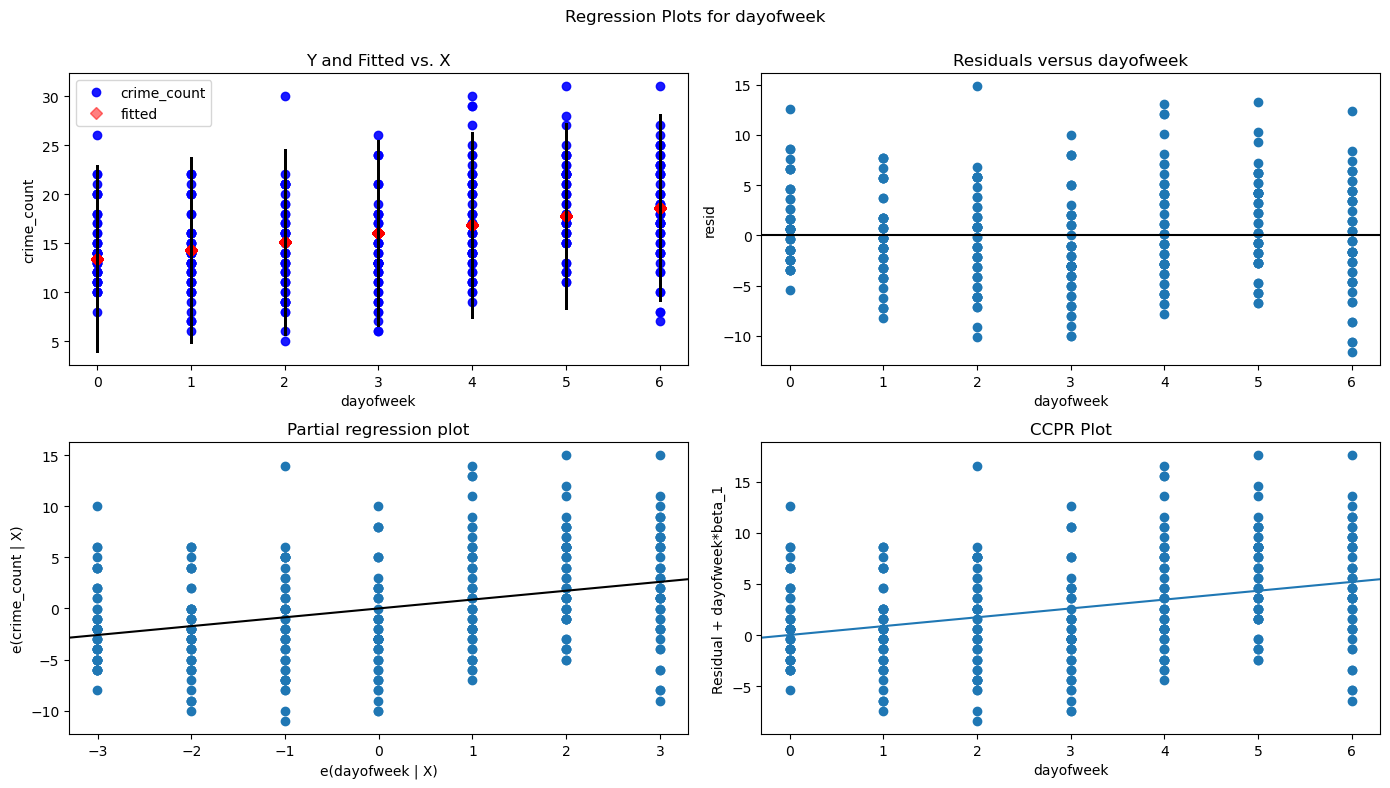

In [116]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_linear,
                                    'dayofweek',
                                    fig=fig)

In [117]:
# independent variable
x = X_train_reg['lag_1']
  
# output variable (dependent)
y = X_train_reg['crime_count']
  
# adding constant
x = sm.add_constant(x)
  
#fit linear regression model
model_linear = sm.OLS(y, x).fit()
  
#display model summary
print(model_linear.summary())
  
# residual sum of squares
print(model_linear.ssr)

                            OLS Regression Results                            
Dep. Variable:            crime_count   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     11.30
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           0.000860
Time:                        11:54:10   Log-Likelihood:                -1046.3
No. Observations:                 345   AIC:                             2097.
Df Residuals:                     343   BIC:                             2104.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1564      0.892     14.745      0.0

### From the above two  OLS Regression results(lag_1 and dayofweek), I conclude that dayofweek has better influence on crime count. 

eval_env: 1


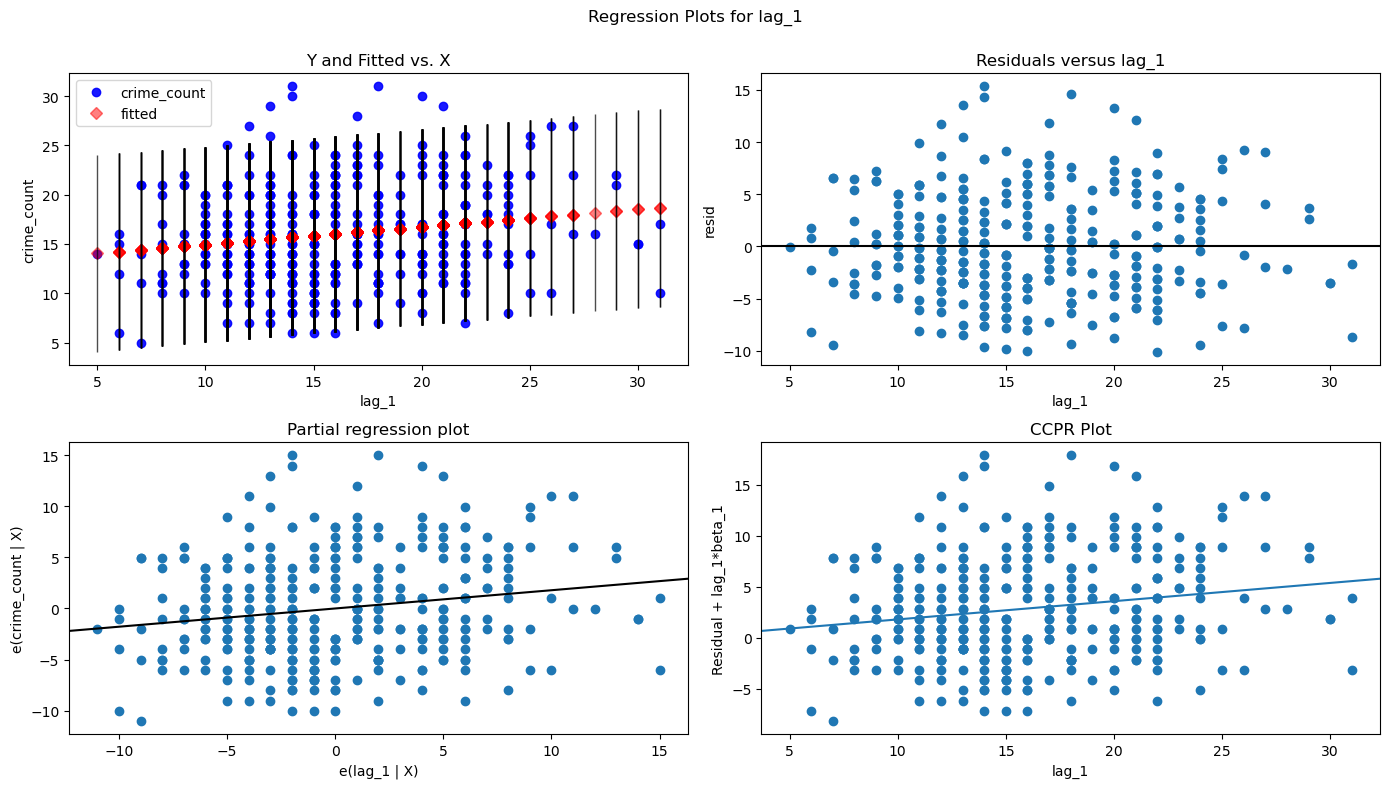

In [118]:
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(model_linear,
                                    'lag_1',
                                    fig=fig)

### Create XGBoost Model<a id='create xgb'>

In [119]:
X_final_train

crime_count
occurred_date             
2022-03-11        2.564949
2022-03-12        2.079442
2022-03-13        3.135494
2022-03-14        2.772589
2022-03-15        2.772589
...                    ...
2023-02-20        3.258097
2023-02-21        2.302585
2023-02-22        2.772589
2023-02-23        2.079442
2023-02-24        2.995732

[351 rows x 1 columns]

In [120]:
def create_features_2(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [121]:
X_train, y_train = create_features_2(X_final_train, label='crime_count')
X_test, y_test = create_features_2(y_final_test, label='crime_count')

In [122]:
import xgboost as xgb

In [123]:
## I have to exclude date column as XGBoost expects an int , float or category. 
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=20,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Featue importances<a id='featuer_importances'>

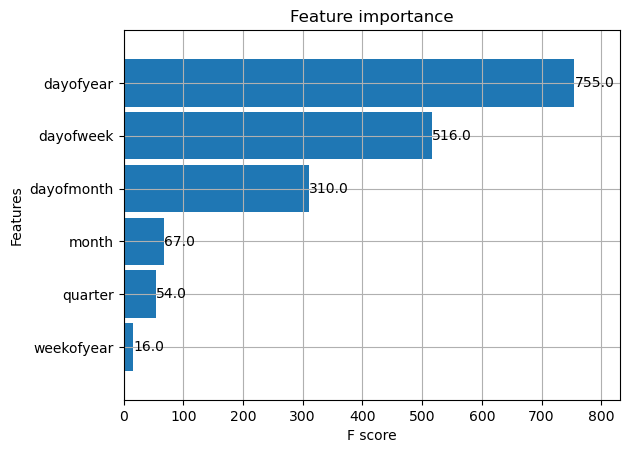

In [124]:
from xgboost import plot_importance
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

### Forecast on test set<a id='forecast_testset'>

In [125]:
y_final_test['crime_prediction'] = reg.predict(X_test)
crime_all = pd.concat([y_final_test, X_final_train], sort=False)

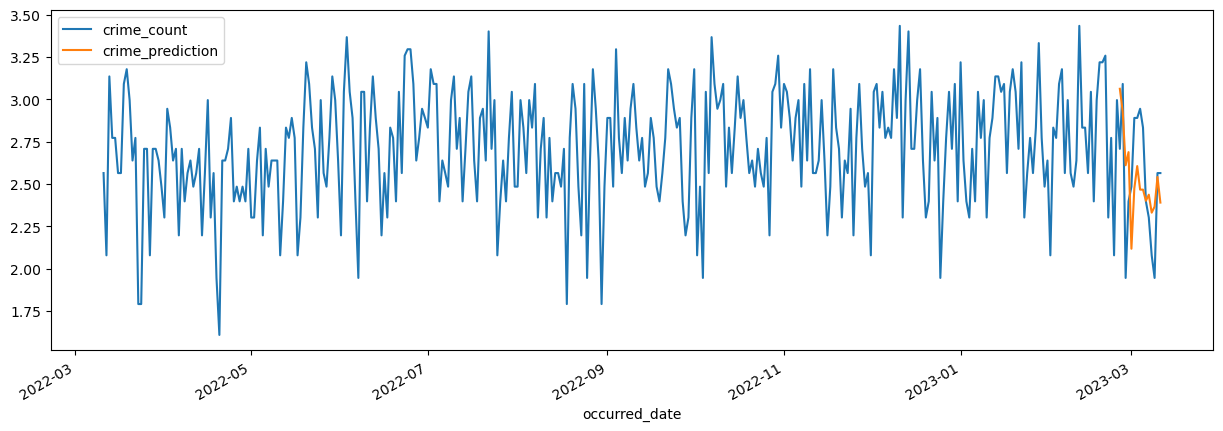

In [126]:
_ = crime_all[['crime_count','crime_prediction']].plot(figsize=(15, 5))

In [127]:
xgb_df = pd.DataFrame({'Actual': y_final_test['crime_count'], 'Predicted': y_final_test['crime_prediction'] })
xgb_df

Actual  Predicted
occurred_date                     
2023-02-25     2.708050   3.062497
2023-02-26     3.091042   2.926598
2023-02-27     1.945910   2.610999
2023-02-28     2.397895   2.688600
2023-03-01     2.484907   2.118254
2023-03-02     2.890372   2.474351
2023-03-03     2.890372   2.606218
2023-03-04     2.944439   2.467227
2023-03-05     2.833213   2.467227
2023-03-06     2.397895   2.401279
2023-03-07     2.302585   2.437386
2023-03-08     2.079442   2.331286
2023-03-09     1.945910   2.366837
2023-03-10     2.564949   2.541897
2023-03-11     2.564949   2.390812

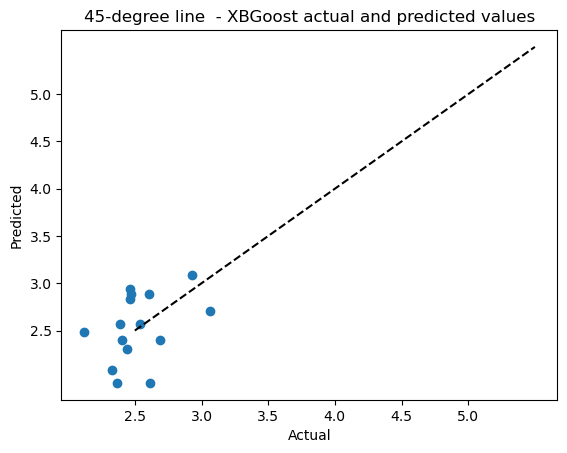

In [128]:
x = xgb_df['Predicted']
y = xgb_df['Actual']
ticks = np.arange( 2.5, 5.5, step=0.5 )

plt.scatter(x, y, cmap='viridis')
plt.xticks( ticks )
plt.yticks( ticks )
plt.plot( [2.5,5.5], [2.5,5.5], linestyle='--', color='k' )
plt.title('45-degree line  - XBGoost actual and predicted values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Error Metrics On Test Set<a id='error_metrics_test_set'>

In [129]:
mean_absolute_error(y_true=xgb_df['Actual'],
                   y_pred=xgb_df['Predicted'])

0.2928570220164526

In [130]:
mean_absolute_percentage_error(y_true=xgb_df['Actual'],
                   y_pred=xgb_df['Predicted'])

12.016073613785066

In [131]:
mean_squared_error(y_true=xgb_df['Actual'],
                   y_pred=xgb_df['Predicted'])

0.11460645123353944

In [132]:
sqrt(mean_squared_error(y_true=xgb_df['Actual'],
                   y_pred=xgb_df['Predicted']))

0.33853574587263224

In [133]:
 r2_score(y_true=xgb_df['Actual'],
                   y_pred=xgb_df['Predicted'])

0.06862525594869728

In [134]:
df_error_metrics = pd.DataFrame({
                   
                   "RMSE": [0.58,0.4,0.43,0.43,0.43,0.33],
                   
                    "MAPE": ['20.97%','14.17%','15.46%','15.7%','13.3%','12.0%']             
                        },
                   index =['Naive','Simple Average' ,'Holt Winter\'s','Arima','uni-step','XGBoost'])
df_error_metrics
  


RMSE    MAPE
Naive           0.58  20.97%
Simple Average  0.40  14.17%
Holt Winter's   0.43  15.46%
Arima           0.43   15.7%
uni-step        0.43   13.3%
XGBoost         0.33   12.0%

## BACKTESTING and TimerSeriesSplit<a id='backtesting'>

Observations: 184
Training Observations: 93
Testing Observations: 91


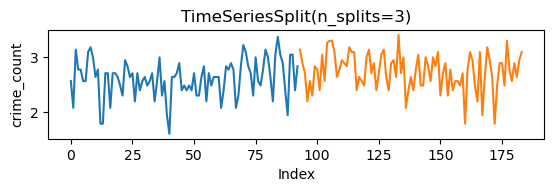

Observations: 275
Training Observations: 184
Testing Observations: 91


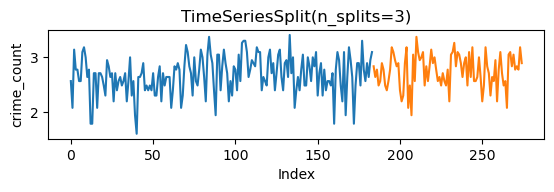

Observations: 366
Training Observations: 275
Testing Observations: 91


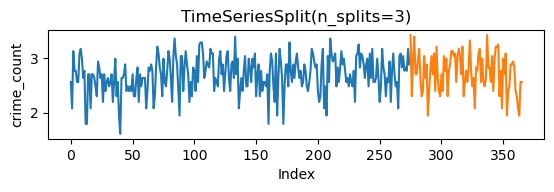

In [135]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = y_log.values
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
    plt.title('TimeSeriesSplit(n_splits=3)')
    plt.xlabel('Index')
    plt.ylabel('crime_count')
    plt.show()

## Summary<a id='summary'>

Applied simple forecast methods as well as some Baseline models like ARIMA, and Uni-step with one lag forecast. Evaluation was done using metrics like RMSE, MAPE. Applied ensemble method  for regression named XGBoost. Of all the models, XGBOOST performed the best with least MAPE
